# My plan so far after experimenting with the data:

drop all cols except for make, model, eventid, event date, amateur built, weather condition, engine type, and the injury totals.

Clean the data using as much of the code I have already written as possible. Define functions early for operations I think will be commmon so I don't have to keep copy pasting them.

group by both make and model in the main df. Make separate DFs that all additionally aggregate based on injury totals, as well as one of amateur built, weather condition, and engine type.

create a statistic that represents the liklihood of any one make an model to be in an accident vs another. Then, add in the comparison of whether they are amateur built, the weather conditions at the time of the incident, and the engine type to see how it changes the distribution.

recommend whether or not amateur built aircraft are safe compared to others

recommend specific makes and models that perform well in bad weather conditions and single out those that do not perform

recommend planes that have a specific engine type that performs well?

make a recommendation of what the best overall aircraft is based on all of these analyses.

## Step 1: import packages and read the CSV into memory

In [1]:
### import packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
### load csv into dataframe
df = pd.read_csv('data/Aviation_Data.csv', low_memory=False)
df.head()

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,...,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980


## Step 2: remove as many uncessary columns as possible

In [2]:
### drop all of the columns I do not plan to use in my analysis
df=df.drop(axis=1, labels=
        ['Investigation.Type', 'Accident.Number', 'Location', 'Country', 'Latitude', 'Longitude', 'Airport.Code', 'Airport.Name', 'Aircraft.damage', 'Aircraft.Category', 'Registration.Number', 'FAR.Description', 'Schedule', 'Purpose.of.flight', 'Air.carrier', 'Broad.phase.of.flight', 'Publication.Date']
       )

In [3]:
### find total number of NaN entries in each column
df.isna().sum()

Event.Id                   1459
Event.Date                 1459
Injury.Severity            2459
Make                       1522
Model                      1551
Amateur.Built              1561
Number.of.Engines          7543
Engine.Type                8536
Total.Fatal.Injuries      12860
Total.Serious.Injuries    13969
Total.Minor.Injuries      13392
Total.Uninjured            7371
Weather.Condition          5951
Report.Status              7840
dtype: int64

In [4]:
### find total number of duplicate rows
df.duplicated().value_counts()

False    88813
True      1535
dtype: int64

## Step 3: remove all duplicate records from the data

In [5]:
### drop all duplicate rows and confirm there are no more duplicates
df = df.drop_duplicates()
df.duplicated().value_counts()

False    88813
dtype: int64

## Step 4: comb through the remaining columns and sort out NaNs

In [6]:
### While it would definitely be easier to just run the .dropna method on the entire dataframe to sort all of these out
### immediately, I determined there were a few special cases in the data that I want to handle manually during my exploration.
### Even though it is inefficient, I will be combing through the columns and sorting out the missing values manually.
df['Event.Id'].isna().sum()

1

In [7]:
### Executing order 66 on all NaNs in the event.id column
df=df.dropna(subset=['Event.Id'])

In [8]:
### confirming we got rid of the event.id NaN entries. It looks like the NaN entries in event.date just
### happened to coincide with the NaN entires of Event.Id, saving me some work!
df.isna().sum()

Event.Id                      0
Event.Date                    0
Injury.Severity             999
Make                         63
Model                        92
Amateur.Built               102
Number.of.Engines          6077
Engine.Type                7074
Total.Fatal.Injuries      11390
Total.Serious.Injuries    12492
Total.Minor.Injuries      11916
Total.Uninjured            5907
Weather.Condition          4491
Report.Status              6379
dtype: int64

In [9]:
### The Injury severity column isn't missing too many values, but the data is extremely irregular and hard to work with for the
### purpose of my analysis, and is made superfluous by the inclusion of the four injury type columns. I think this column should
### only have two values: fatal and non-fatal, so manipulating it into this form is my next goal.

df['Injury.Severity'].value_counts().head(20)

Non-Fatal      67309
Fatal(1)        6161
Fatal           5262
Fatal(2)        3705
Incident        2211
Fatal(3)        1145
Fatal(4)         807
Fatal(5)         235
Minor            217
Serious          173
Fatal(6)         161
Unavailable       96
Fatal(7)          56
Fatal(8)          51
Fatal(10)         32
Fatal(9)          18
Fatal(14)         11
Fatal(11)         10
Fatal(13)          9
Fatal(12)          8
Name: Injury.Severity, dtype: int64

In [10]:
### This cell standardizes the non-fatal values, removes NaNs, and drops a placeholder value that I found.

df['Injury.Severity'] = df['Injury.Severity'].replace(to_replace=['Incident', 'Minor', 'Serious'], value='Non-Fatal')
df = df.drop(df[df['Injury.Severity'] == 'Unavailable'].index)
df.dropna(axis=0, subset=['Injury.Severity'], inplace=True)
df['Injury.Severity'].value_counts().head(20)

Non-Fatal    69910
Fatal(1)      6161
Fatal         5262
Fatal(2)      3705
Fatal(3)      1145
Fatal(4)       807
Fatal(5)       235
Fatal(6)       161
Fatal(7)        56
Fatal(8)        51
Fatal(10)       32
Fatal(9)        18
Fatal(14)       11
Fatal(11)       10
Fatal(13)        9
Fatal(12)        8
Fatal(15)        5
Fatal(20)        5
Fatal(18)        5
Fatal(23)        4
Name: Injury.Severity, dtype: int64

In [11]:
### This is the cell that standardizes the different types of fatal entry under a single string. It just looks to see if the
### first five characters of the entry are 'fatal' and if they are, it sets the entry to 'fatal'.

df['Injury.Severity'] = df['Injury.Severity'].map(lambda x: 'Fatal' if x[:5]=='Fatal' else x)

In [12]:
### Showing that the above code performs the operation I set out to do

df['Injury.Severity'].value_counts().head(20)

Non-Fatal    69910
Fatal        17807
Name: Injury.Severity, dtype: int64

In [13]:
### Now I need to handle the make and model columns. They are both categorical and do not appear to have any placeholder values,
### so I just drop their NaN values after having a look at them.

df['Make'].value_counts().head(20)

Cessna               22194
Piper                12010
CESSNA                4841
Beech                 4324
PIPER                 2814
Bell                  2113
Boeing                1529
Mooney                1092
Grumman               1091
BEECH                 1025
Robinson               941
Bellanca               886
Hughes                 793
BOEING                 720
Schweizer              627
Air Tractor            594
BELL                   570
Mcdonnell Douglas      515
Aeronca                486
Maule                  445
Name: Make, dtype: int64

In [14]:
df.dropna(axis=0, subset=['Make'], inplace=True)

In [15]:
df['Model'].value_counts().head(20)

152          2353
172          1742
172N         1161
PA-28-140     930
150           825
172M          797
172P          685
182           656
180           622
150M          585
PA-18         579
PA-18-150     578
PA-28-180     571
PA-28-161     568
PA-28-181     528
206B          520
PA-38-112     467
150L          461
G-164A        460
A36           450
Name: Model, dtype: int64

In [16]:
df.dropna(axis=0, subset=['Model'], inplace=True)

In [17]:
### Checking the results of that last operation

df.isna().sum()

Event.Id                      0
Event.Date                    0
Injury.Severity               0
Make                          0
Model                         0
Amateur.Built                89
Number.of.Engines          5247
Engine.Type                6178
Total.Fatal.Injuries      11291
Total.Serious.Injuries    12388
Total.Minor.Injuries      11813
Total.Uninjured            5809
Weather.Condition          3512
Report.Status              5441
dtype: int64

In [18]:
df['Amateur.Built'].value_counts().head()

No     79111
Yes     8427
Name: Amateur.Built, dtype: int64

In [19]:
### This column seems like it would be easier to work with if the data was in boolean format. The code below drops the NaN values
### and manipulates it into that format by mapping 'yes' to true and anything else to false.
df.dropna(subset=['Amateur.Built'], inplace=True)
df['Amateur.Built'] = df['Amateur.Built'].map(lambda x: True if x=='Yes' else False)
df['Amateur.Built'].value_counts().head()

False    79111
True      8427
Name: Amateur.Built, dtype: int64

In [20]:
print(df['Number.of.Engines'].value_counts().head(10))
print(df['Number.of.Engines'].mean())

1.0    69428
2.0    10831
0.0     1204
3.0      482
4.0      411
8.0        3
6.0        1
Name: Number.of.Engines, dtype: int64
1.1438805245264692


In [21]:
### I plan to use the number of engines in my analysis, but I don't think it's important enough to me to delete the roughly 6% 
### of total records that have a NaN for this column. It doesn't really make sense to fill it with the mean either, because 
### this column is exclusively integer values, and the mean would be a float. Instead, I think it makes the most sense to just
### fill the NaNs in this column with the median.

df['Number.of.Engines'].fillna(df['Number.of.Engines'].median(), inplace=True)
df.isna().sum()

Event.Id                      0
Event.Date                    0
Injury.Severity               0
Make                          0
Model                         0
Amateur.Built                 0
Number.of.Engines             0
Engine.Type                6110
Total.Fatal.Injuries      11235
Total.Serious.Injuries    12309
Total.Minor.Injuries      11730
Total.Uninjured            5750
Weather.Condition          3464
Report.Status              5441
dtype: int64

In [22]:
### Checking to see how that operation affected the data. It looks like it very slightly lowered the mean value by assuming
### all the NaNs were planes with 1 engine, which should be perfectly fine for my analysis. 
print(df['Number.of.Engines'].value_counts().head(10))
print(df['Number.of.Engines'].mean())

1.0    74606
2.0    10831
0.0     1204
3.0      482
4.0      411
8.0        3
6.0        1
Name: Number.of.Engines, dtype: int64
1.1353697822659874


In [23]:
### Now, it's time to work with the Engine Type data. Judging by the outcome of the value counts calls below and the number of
### NaNs in the column, it is going to be hard to use this data without significant effort to clean it.
print(df['Engine.Type'].value_counts(normalize=True).head(10))

Reciprocating    0.852385
Turbo Shaft      0.044125
Turbo Prop       0.041288
Turbo Fan        0.028786
Unknown          0.024439
Turbo Jet        0.008560
None             0.000233
Electric         0.000098
NONE             0.000025
LR               0.000025
Name: Engine.Type, dtype: float64


In [24]:
df['Engine.Type'].value_counts()

Reciprocating      69408
Turbo Shaft         3593
Turbo Prop          3362
Turbo Fan           2344
Unknown             1990
Turbo Jet            697
None                  19
Electric               8
NONE                   2
LR                     2
UNK                    1
Hybrid Rocket          1
Geared Turbofan        1
Name: Engine.Type, dtype: int64

In [25]:
### My strategy to clean the data is as follows: First, I will simply drop the none values, since they are such a small subset
### of the total. Then, I will fill the NaNs with the 'unknown' placeholder value. After that, I will randomly assign values to
### the unknown values according to the normal distribution of the categorical data, NOT including outliers with only 1-2 values. 
### (This is an idea I'm taking from a solution branch in a previous lab, but I'm rewriting it to be tailored for my specific
### purpose, based on my own understanding of how it works. Note to self: as the instructor if the code I came up with here is ok.)
df['Engine.Type'] = df['Engine.Type'].loc[df['Engine.Type'] != 'NONE']
df['Engine.Type'] = df['Engine.Type'].loc[df['Engine.Type'] != 'None']
df['Engine.Type'].fillna(value='Unknown', inplace=True)
df['Engine.Type'].value_counts(normalize=True)

Reciprocating      0.792890
Unknown            0.092771
Turbo Shaft        0.041045
Turbo Prop         0.038406
Turbo Fan          0.026777
Turbo Jet          0.007962
Electric           0.000091
LR                 0.000023
UNK                0.000011
Hybrid Rocket      0.000011
Geared Turbofan    0.000011
Name: Engine.Type, dtype: float64

In [26]:
### Grab the current normal distribution of the values by converting normalized value counts to a dict and
### assigning the values to a list variable. Then, remove extreme outliers and Unknowns.

norms = dict(df['Engine.Type'].value_counts(normalize=True))
remove_list = ['Unknown', 'Electric', 'LR', 'UNK', 'Geared Turbofan', 'Hybrid Rocket']
for key in remove_list:
    del norms[key]
norms = list(norms.values())
norms

[0.7928899449381983,
 0.041045031871872785,
 0.03840617788845987,
 0.026776942584934543,
 0.007962256391509973]

In [27]:
### Now that I have a list of normalized values for each of the remaining entries in this column, I need to convert these values
### into probabilities that I can instruct numpy to consider while it is assigning new values to unknowns randomly. To do this,
### I need to determine the relative percentage of each of these values to their sum.

probabilities = []
for number in norms:
    probabilities.append(number/sum(norms))
probabilities

[0.8741121354087955,
 0.045249609591456345,
 0.042340436250062966,
 0.029519923429550145,
 0.008777895320135004]

In [28]:
### Now that I have the list of probabilities for each value I want to fill the Unknowns with, I can finally write the call
### that will replace the unknowns for me. I am simply going to write a lambda function to do this, since I only plan on doing it
### once.

df['Engine.Type'] = df['Engine.Type'].map(lambda x: np.random.choice(['Reciprocating', 'Turbo Shaft', 'Turbo Prop', 'Turbo Fan', 'Turbo Jet'], p=probabilities) if x=='Unknown' else x)
df['Engine.Type'].value_counts(normalize=True)

Reciprocating      0.873701
Turbo Shaft        0.045169
Turbo Prop         0.042736
Turbo Fan          0.029336
Turbo Jet          0.008910
Electric           0.000091
LR                 0.000023
UNK                0.000011
Hybrid Rocket      0.000011
Geared Turbofan    0.000011
Name: Engine.Type, dtype: float64

In [29]:
### It looks like that worked exactly how I wanted it to! This definitely has an affect on the summary statistics of this
### column, but it's a more acceptable effect than just dropping over 5% of the values would be. Next, I'll check the 
### amount of NaNs in the data again.
df.isna().sum()

Event.Id                      0
Event.Date                    0
Injury.Severity               0
Make                          0
Model                         0
Amateur.Built                 0
Number.of.Engines             0
Engine.Type                   0
Total.Fatal.Injuries      11235
Total.Serious.Injuries    12309
Total.Minor.Injuries      11730
Total.Uninjured            5750
Weather.Condition          3464
Report.Status              5441
dtype: int64

In [30]:
### Next on the list are the counts of individuals who were injured/uninjured in each incident. These have a lot of NaN values
### for some reason. The grand majority of incidents did not have any fatalities, and many of the incidents that did have fatalities
### have a unique number of fatalities. For this reason, I don't think it's reasonable to fill the NaNs with the normal distribution
### of values, as we may assign a 0 to an incident that has a 'fatal' value in the Injury.Severity column.

### My strategy to handle this column is to first test if there are any cases where Injury.Severity says there is a fatality but
### Total.Fatal.Injuries has a NaN value. If it does not, it should be perfectly fine for me to just fill the NaNs with 0s.
df['Total.Fatal.Injuries'].value_counts(normalize=True).head()

0.0    0.767663
1.0    0.115998
2.0    0.067494
3.0    0.020668
4.0    0.014364
Name: Total.Fatal.Injuries, dtype: float64

In [31]:
temp_df = df.loc[df['Injury.Severity'] == 'Fatal']

In [32]:
temp_df.isna().sum()

Event.Id                     0
Event.Date                   0
Injury.Severity              0
Make                         0
Model                        0
Amateur.Built                0
Number.of.Engines            0
Engine.Type                  0
Total.Fatal.Injuries         0
Total.Serious.Injuries    2615
Total.Minor.Injuries      2914
Total.Uninjured           2947
Weather.Condition         1507
Report.Status             2232
dtype: int64

In [33]:
### Looks like there are no cases that meet the criteria that I set out, so I am just going to fill that column's NaNs with 0s.
df['Total.Fatal.Injuries'].fillna(value=0.0, inplace=True)

In [34]:
df.isna().sum()

Event.Id                      0
Event.Date                    0
Injury.Severity               0
Make                          0
Model                         0
Amateur.Built                 0
Number.of.Engines             0
Engine.Type                   0
Total.Fatal.Injuries          0
Total.Serious.Injuries    12309
Total.Minor.Injuries      11730
Total.Uninjured            5750
Weather.Condition          3464
Report.Status              5441
dtype: int64

In [35]:
### The next order of business is to figure out the serious and minor injury columns. I am unconvinced that I actually need these
### two columns; I feel like the total number of fatal injuries and the total number of uninjured passengers in combination with 
### the injury.severity column is probably already enough information for my analysis. For now, I'm just
### going to drop those two columns to save myself the headache of figuring out how to deal with each of them having 10-12% of
### values as NaN.
df=df.drop(axis=1, labels=['Total.Serious.Injuries', 'Total.Minor.Injuries'])

In [36]:
### Now I need to deal with the Total.Uninjured column. Roughly 7% of all entries have NaN in this column, and I'm not comfortable
### dropping that many values. I think in this case I'd like to just fill with the median value and call it a day, because accuracy
### in this specific category is not vitally important to the accuracy of my analysis. 

df['Total.Uninjured'].value_counts(normalize=True).head(10)

0.0    0.352326
1.0    0.306573
2.0    0.194980
3.0    0.052575
4.0    0.032474
5.0    0.010808
6.0    0.006089
7.0    0.003399
8.0    0.001956
9.0    0.001553
Name: Total.Uninjured, dtype: float64

In [37]:
df['Total.Uninjured'].fillna(df['Total.Uninjured'].median(), inplace=True)
df['Total.Uninjured'].value_counts(normalize=True).head(10)

1.0    0.352121
0.0    0.329183
2.0    0.182172
3.0    0.049122
4.0    0.030341
5.0    0.010098
6.0    0.005689
7.0    0.003176
8.0    0.001828
9.0    0.001451
Name: Total.Uninjured, dtype: float64

In [38]:
### That caused a significant change in the distribution where 1.0 became the most common value, but the other effects on the
### the distribution seem pretty minor to me. I'm happy to leave it like this at the moment, and will revisit to apply the 
### same method I used on the engine.type column earlier if I decide greater accuracy is necessary. Now, I'll investigate the
### last two columns.
df['Weather.Condition'].value_counts(normalize=True)

VMC    0.916597
IMC    0.070735
UNK    0.009848
Unk    0.002819
Name: Weather.Condition, dtype: float64

In [39]:
### I think this column will play an important role in my analysis, so I want to preserve the original data as much as I possibly can.
### I will drop the NaNs, and for the unknowns, I plan to just assign them to VMC because it is more common. The bonus of this
### is that it will preserve the cases with IMC weather conditions, which will help me to analyze which makes and models perform
### best under poor weather conditions accurately - High visibility condition cases are of little use to me. 

df.dropna(axis=0, subset=['Weather.Condition'], inplace=True)
df.loc[df['Weather.Condition'] == 'UNK', 'Weather.Condition'] = 'VMC'
df.loc[df['Weather.Condition'] == 'Unk', 'Weather.Condition'] = 'VMC'
df['Weather.Condition'].value_counts(normalize=True)

VMC    0.929265
IMC    0.070735
Name: Weather.Condition, dtype: float64

In [40]:
### I'm happy with the accuracy of this result. Time to check the last Column!
df['Report.Status'].value_counts()

Probable Cause                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        61568
Foreign                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [41]:
### This column is extremely interesting. It may help us to gain some insight into the specific failures that caused fatal
### accidents. Unfortunately, the data is extremely irregular in nature and contains missing values. We can't really use it
### for concrete statistical analysis, so I think it's definitely best just to give it the drop.
df = df.drop(axis=1, labels='Report.Status')
df.isna().sum()

Event.Id                0
Event.Date              0
Injury.Severity         0
Make                    0
Model                   0
Amateur.Built           0
Number.of.Engines       0
Engine.Type             0
Total.Fatal.Injuries    0
Total.Uninjured         0
Weather.Condition       0
dtype: int64

## Step 5: statistical analysis

In [42]:
### Group by make and model, and then count up the total number of incidents for each. Turn the grouped structure back into a 
### dataframe, combine make and model labels into a new column, then delete the originals. Trim the data to the top 20 results
### and then plot it.
total_incidents = df.groupby(['Make', 'Model']).size().sort_values()
total_incidents=total_incidents.reset_index()
total_incidents=total_incidents.rename(columns={0:'Incident Count'})
total_incidents['Make&Model'] = total_incidents['Make'] + ' ' + total_incidents['Model']
total_incidents.drop(axis=1, labels=['Make', 'Model'], inplace=True)
total_incidents = total_incidents.tail(20)

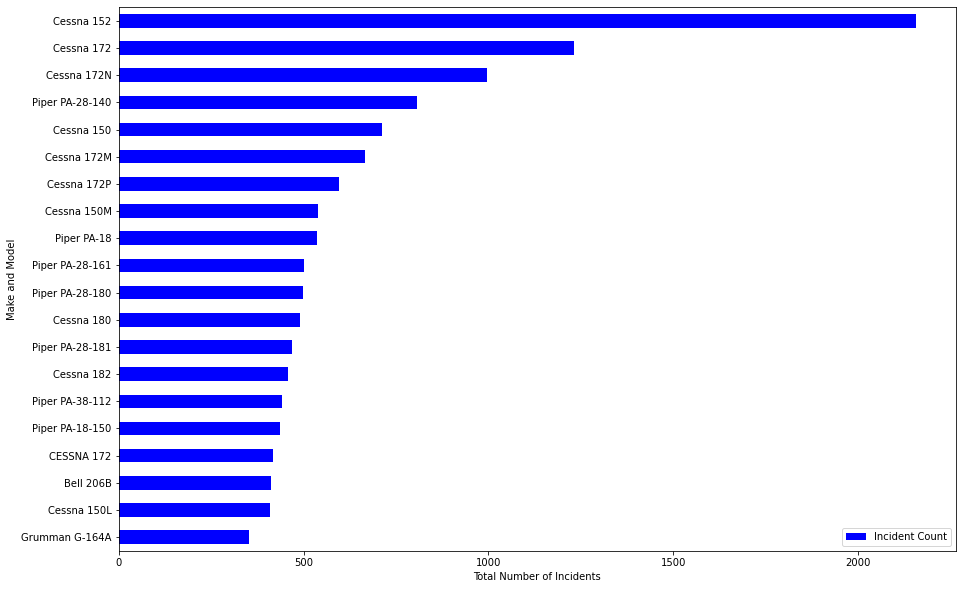

In [43]:
ax = total_incidents.plot.barh(y='Incident Count', x='Make&Model', figsize=(15,10), color='Blue', ylabel='Make and Model')
ax.set_ylabel('Make and Model')
ax.set_xlabel('Total Number of Incidents');

As we can see above, the makes and models with the highest total number of incidents are Piper and Cessna airplanes, which are all low-capacity consumer grade aircraft. It makes sense that so many of the incidents would be related to these aircraft as they are typically used to train new pilots and as recreational craft by hobbyists, who do not follow the same safety requirements as professional pilots. These planes also lack many of the features of larger commercial aircraft.

But which makes and models have the highest total number of fatalities attributed to them?

In [44]:
total_fatalities = df.groupby(['Make', 'Model'])['Total.Fatal.Injuries'].sum().sort_values()
total_fatalities=total_fatalities.reset_index()
total_fatalities['Make&Model'] = total_fatalities['Make'] + ' ' + total_fatalities['Model']
total_fatalities.drop(axis=1, labels=['Make', 'Model'], inplace=True)
total_fatalities = total_fatalities.tail(20)

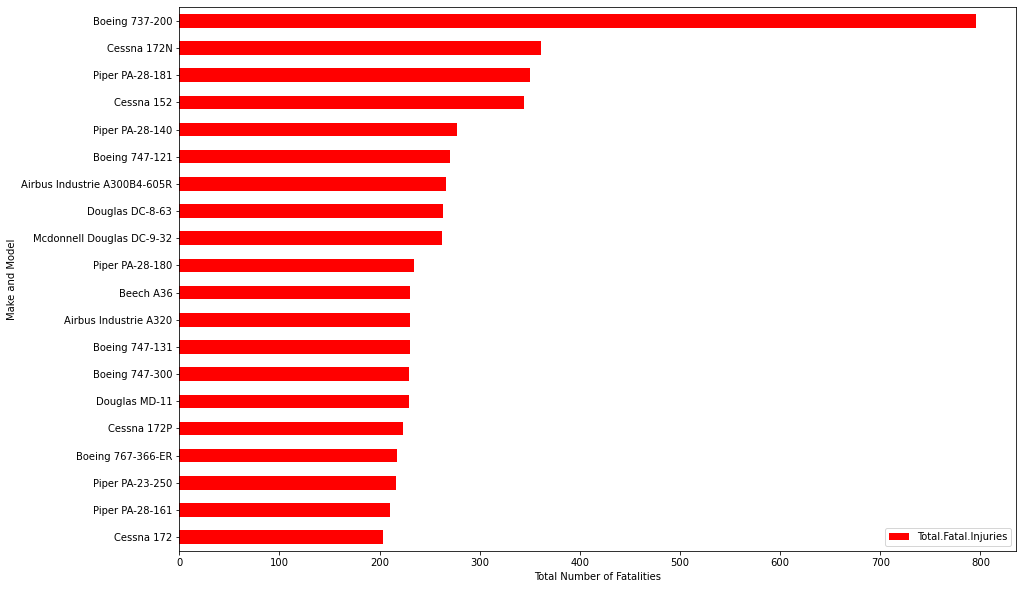

In [45]:
ax = total_fatalities.plot.barh(y='Total.Fatal.Injuries', x='Make&Model', figsize=(15,10), color='Red', ylabel='Make and Model')
ax.set_ylabel('Make and Model')
ax.set_xlabel('Total Number of Fatalities');

In [51]:
amateur_built = df.groupby(['Make', 'Model'])['Amateur.Built'].size().sort_values()
amateur_built

Make                      Model              
107.5 Flying Corporation  One Design DR 107         1
MORRIS THOMAS LEE         STOLP STRDSTR SA300       1
MORRISEY                  2150                      1
MORRISON                  E-RACER                   1
MORRISON JOSEPH           Q2                        1
                                                 ... 
Cessna                    150                     712
Piper                     PA-28-140               806
Cessna                    172N                    995
                          172                    1231
                          152                    2156
Name: Amateur.Built, Length: 19120, dtype: int64